In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm
import seaborn as sns
import cv2
import io


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import ipywidgets as widgets
from tensorflow.keras.utils import to_categorical

from PIL import Image
from warnings import filterwarnings

from IPython.display import display, clear_output

In [4]:
#pip install ipywidgets


In [2]:
# AD = []
# for i in os.listdir('../input/parkinsonproject/Parkinson/trainDatasets/AD/'):
#   AD.append()

# AD.drop("")

# ".DS_store" in AD

In [3]:
labels = ["CONTROL", "AD", "PD"]

In [4]:
X_train  =[] # Training Datasets
Y_train = [] # Training Labels

image_size = 150

for i in labels:
    folderpath= os.path.join("AD_PD_Final/3_cls/", "train", i)
    for j in tqdm(os.listdir(folderpath)):
        image  = cv2.imread(os.path.join(folderpath, j))
        image = cv2.resize(image, (image_size, image_size))
        
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderpath= os.path.join("AD_PD_Final/3_cls/", "test", i)
    for j in tqdm(os.listdir(folderpath)):
        image  = cv2.imread(os.path.join(folderpath, j))
        image = cv2.resize(image, (image_size, image_size))
        
        X_train.append(image)
        Y_train.append(i)
        
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 123.94it/s]


In [5]:
X_train.shape

(7839, 150, 150, 3)

In [6]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=101)

In [7]:
X_train.shape

(7839, 150, 150, 3)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=101)

In [9]:
Y_train[0]

'CONTROL'

In [10]:
y_train_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))
    
Y_train = y_train_new
Y_train = to_categorical(Y_train)

for i in Y_test:
    y_test_new.append(labels.index(i))
    
Y_test = y_test_new
Y_test = to_categorical(Y_test)

In [11]:
Y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [12]:
np.argmax(Y_train[40])

0

EfficientNetB5(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs
)

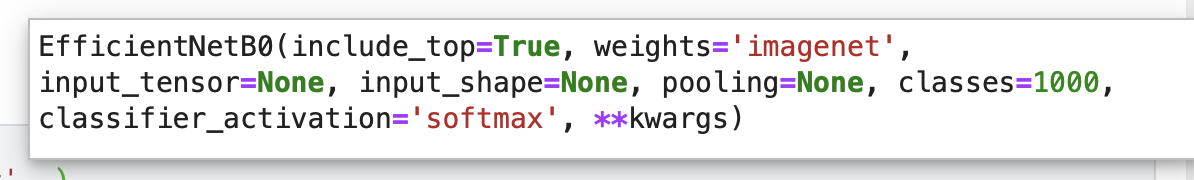

In [16]:
efficient = EfficientNetB5(weights='imagenet',include_top = False, input_shape=(image_size, image_size, 3)) 

115263384/115263384 [==============================] - 12s 0us/step


In [18]:
import tensorflow as tf

In [19]:
model = efficient.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(3, activation = "softmax")(model)

model = tf.keras.models.Model(inputs = efficient.input , outputs = model)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 150, 150, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

In [21]:
model.compile(loss = 'categorical_crossentropy', 
             optimizer = "Adam", 
              metrics=["accuracy"]
             )

In [22]:
tensorboard = TensorBoard(log_dir="logs")
checkpoint = ModelCheckpoint("efficient.h5", 
                            monitor='val_accuracy', 
                            mode = "auto", 
                            verbose = 1,
                            save_best_only =True)
reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", 
                             factor = 0.3, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

In [1]:
history = model.fit(X_train, Y_train,
                  validation_split = 0.1, 
                  epochs = 10, 
                  verbose =1, 
                  batch_size = 32, 
                  callbacks = [tensorboard, checkpoint, reduce_LR])

NameError: name 'model' is not defined

In [24]:
def accuracy_and_loss_Plot(modelData):
    
    fig = plt.figure(figsize = (10, 10))
    
    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--', label = 'accuracy')
    plt.plot(modelData.history["val_accuracy"], 'ro--', label = 'val_accuracy')
    plt.title("Training Data Accuracy Measurement")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    
    
    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--', label = 'loss')
    plt.plot(modelData.history["val_loss"], 'ro--', label = 'val_loss')
    plt.title("Training Data Loss Measurement")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()

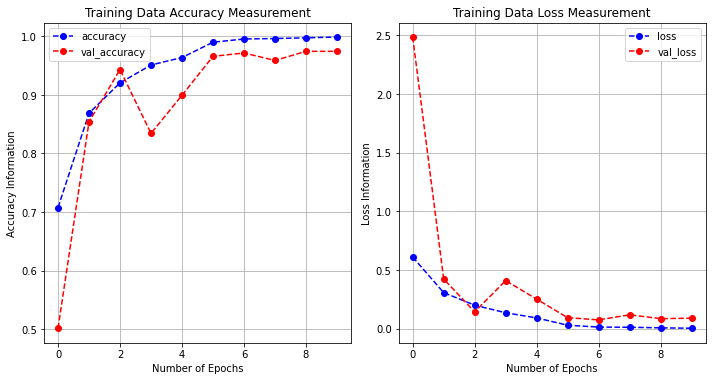

In [25]:
accuracy_and_loss_Plot(history)

In [26]:
pred = model.predict(X_test)


25/25 [==============================] - 26s 956ms/step


In [27]:
model.evaluate(X_test,Y_test)

25/25 [==============================] - 26s 1s/step - loss: 0.1230 - accuracy: 0.9681


[0.12302379310131073, 0.9681122303009033]

In [28]:

pred=np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test, axis = 1)

In [29]:
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       390
           1       0.99      0.97      0.98       322
           2       0.89      0.93      0.91        72

    accuracy                           0.97       784
   macro avg       0.95      0.96      0.95       784
weighted avg       0.97      0.97      0.97       784



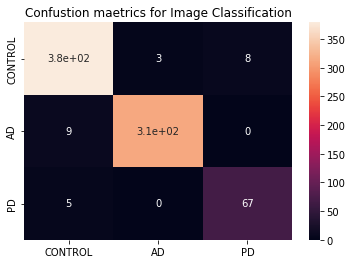

In [33]:
Cm = confusion_matrix(y_test_new, pred)
ax = plt.axes()
sns.heatmap(Cm, annot=True, 
           annot_kws={'size':10}, 
           xticklabels=labels,
           yticklabels=labels, 
           ax = ax)

plt.title("Confustion maetrics for Image Classification")
plt.show()


In [34]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "CONTROL"
    elif prd == 1:
        prd = "AD"
    elif prd ==2:
        prd = "PD"
        
    if prd!=1:
        print(f"Model Predict That is  a {prd}")

In [39]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value=(), description='Upload')

In [41]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])